In [1]:
import pandas as pd
import numpy as np

from interpret.glassbox import ExplainableBoostingClassifier as ebc
from interpret.glassbox import ExplainableBoostingRegressor as ebr
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as auc
from interpret import show
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def clip_outliers(df):
    for col in df.columns:
        try:
            df[col] = np.clip(df[col], np.percentile(df[col], 0.1), np.percentile(df[col], 99.9))
        except:
            pass
    return df

def fillna_unknown_dtype_col(X):
    if X.dtype == np.int or X.dtype == np.int64:
        X = X.fillna(value=-1)
    elif X.dtype == np.float:
        X = X.fillna(value=-1)
    elif X.dtype == np.bool:
        X = X.fillna(value=False)
    elif X.dtype == np.object:
        X = X.fillna(value='missing')
    else:
        print(X.dtype)
    return X

In [3]:
# Load MIMIC-II
def load_mimic2():
    df = pd.read_csv("mimic2/mimic2_rfimputed.csv")
    Y = df['HospitalMortality']
    X = df.copy()
    X = X.drop("HospitalMortality", axis=1)
    print(X.shape)
    return X, Y
mimic2_X, mimic2_Y = load_mimic2()

(24508, 17)


In [4]:
# Load MIMIC-III as tabular dataset.
def load_mimic3():
    df = pd.read_csv("/Users/blengerich/Dropbox/Professional/Research/Data/MIMIC/MIMIC3_Parsed/MIMIC/tabular/adult_icu")
    X = df
    y = df['mort_icu'].values

    remove_cols = ['train', 'mort_icu', 'icustay_id', 'hadm_id', 'subject_id', 'adult_icu', 'admType_NEWBORN',
                   'sysbp_mean', 'sysbp_min', 'admType_ELECTIVE', 'admType_EMERGENCY', 'admType_URGENT', 
                   'heartrate_min', 'heartrate_mean',
                  'tempc_min', 'tempc_mean', 
                   'spo2_min', 'spo2_mean', 'spo2_max',
                   'glucose_min', 'glucose_max', 'first_hosp_stay', 'first_icu_stay',
                  'eth_asian', 'eth_other', 'eth_white', 'eth_black', 'eth_hispanic',
                  'resprate_min', 'resprate_mean', 'resprate_max',
                   'diasbp_max', 'diasbp_mean',
                  'meanbp_min', 'meanbp_mean', 'meanbp_max',
                  'hematocrit', 'bilirubin', 'hemoglobin']
    feature_names = list([x for x in df.columns.values if x not in remove_cols ])
    for col in remove_cols:
        del X[col]
    return X, y
mimic3_X, mimic3_Y = load_mimic3()

In [5]:
# Load MIMIC-IV as tabular dataset.
def load_mimic4():
    df = pd.read_csv("mimic4/mimic4_flat_large.csv", low_memory=False)
    df_cols = df.columns.tolist()
    # Match lab values to the ones used in the previous 2 MIMIC datasets.
    lab_cols = [
        'ART BP Diastolic',
        'ART BP Systolic',
        'Aortic Pressure Signal - Diastolic',
        'Aortic Pressure Signal - Systolic',
        'Arterial Blood Pressure diastolic',
        'Arterial Blood Pressure systolic',
        'Albumin',
        'Direct Bilirubin',
        'BUN',
        'Calcium Chloride',
        'Chloride (serum)',
        'Creatinine (serum)',
        'Cerebral Temperature (C)',
        'Glucose (serum)',
        'Hematocrit (serum)',
        'Hemoglobin',
        'Magnesium',
        'PTT',
        'Platelet Count',
        'Potassium (serum)',
        'Sodium (serum)',
        'Temperature Fahrenheit',
        'Temperature Site',
        'Skin Temperature',
        'RLE Temp',
        'RUE Temp',
        'Total Bilirubin',
        'WBC',]
    df.drop('Communication', axis=1, inplace=True)
    demo_cols = ['admission_type', 'insurance', 'marital_status', 'ethnicity', 'gender', 'age']
    treatment_cols = df_cols[df_cols.index('mortality')+1:df_cols.index('Insulin - Novolog')+1]
    treatment_cols = [x for x in treatment_cols if x != 'Communication']
    treatment_cols = np.array(treatment_cols)[np.sum(df[treatment_cols], axis=0) > 100]

    X_demo = df[demo_cols]
    X_treatments = df[treatment_cols]
    X_labs = clip_outliers(df[lab_cols])
    fill_values = {}
    for i in range(X_demo.shape[1]):
        if X_demo.values[0, i].__class__ == str:
            fill_values[i] = 'Missing'
        elif X_demo.values[0, i].__class__ == bool:
            fill_values[i] = False
        elif X_demo.values[0, i].__class__ == float or X_demo.values[0, i].__class__ == int:
            fill_values[i] = -1
    for j in range(X_labs.shape[1]):
        if X_labs.values[0, j].__class__ == str:
            fill_values[i+j] = 'Missing'
        elif X_labs.values[0, j].__class__ == bool:
            fill_values[i+j] = False
        elif X_labs.values[0, j].__class__ == float or X_labs.values[0, j].__class__ == int:
            fill_values[i+j] = -1
    X = pd.concat([X_demo, X_labs], axis=1).fillna(value=fill_values)
    Y = df['mortality']
    for feat in X.columns:
        X[feat] = fillna_unknown_dtype_col(X[feat])

    return X, Y, X_treatments

mimic4_X, mimic4_Y, mimic4_treatments = load_mimic4()

/Users/blengerich/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/blengerich/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # R

['AIDS', 'AdmissionType', 'Age', 'Bilirubin', 'CO2', 'GCS', 'HR', 'K', 'Lymphoma', 'MetastaticCancer', 'Na', 'PFratio', 'Renal', 'SBP', 'Temperature', 'Urea', 'WBC']
['age', 'albumin', 'aniongap', 'bicarbonate', 'bun', 'chloride', 'creatinine', 'diasbp_min', 'glucose', 'glucose_mean', 'heartrate_max', 'inr', 'lactate', 'magnesium', 'phosphate', 'platelet', 'potassium', 'pt', 'ptt', 'sodium', 'sysbp_max', 'tempc_max', 'wbc']
['ART BP Diastolic', 'ART BP Systolic', 'Albumin', 'Aortic Pressure Signal - Diastolic', 'Aortic Pressure Signal - Systolic', 'Arterial Blood Pressure diastolic', 'Arterial Blood Pressure systolic', 'BUN', 'Calcium Chloride', 'Cerebral Temperature (C)', 'Chloride (serum)', 'Creatinine (serum)', 'Direct Bilirubin', 'Glucose (serum)', 'Hematocrit (serum)', 'Hemoglobin', 'Magnesium', 'PTT', 'Platelet Count', 'Potassium (serum)', 'RLE Temp', 'RUE Temp', 'Skin Temperature', 'Sodium (serum)', 'Temperature Fahrenheit', 'Temperature Site', 'Total Bilirubin', 'WBC', 'admissi

/Users/blengerich/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/blengerich/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


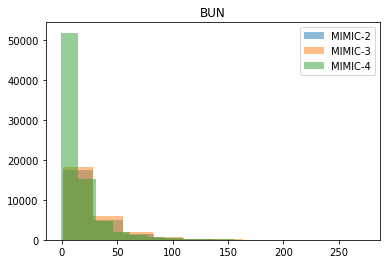

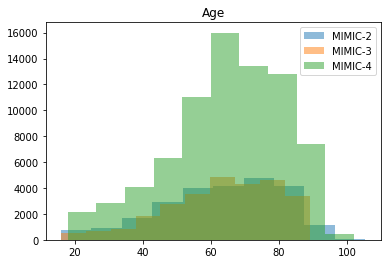

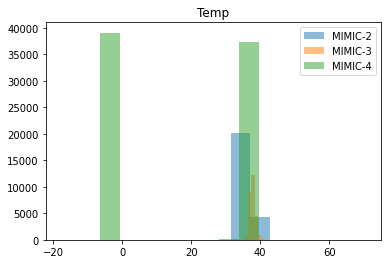

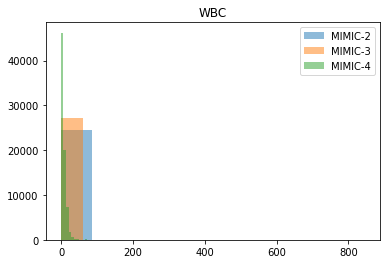

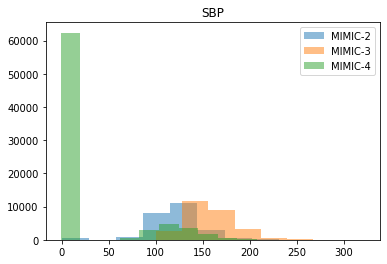

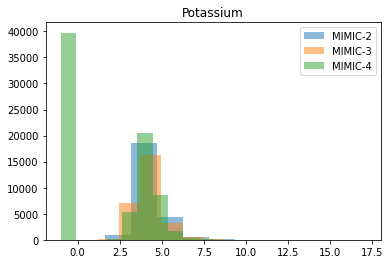

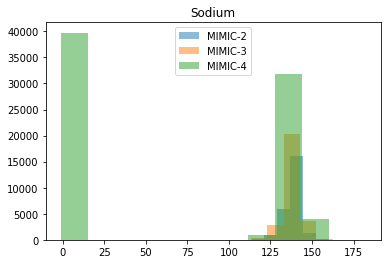

In [25]:
# Unify feature names.
unified_features = ['Age', 'BUN', 'Albumin', 'Bilirubin', 'Chloride', 'Creatinine',
                    'Glucose', 'HeartRate', 'Magnesium', 'Sodium', 'SBP', 'Temp',
                    'Platelet', 'Potassium', 'WBC']

mimic2_X_sel = mimic2_X[["Age", "Bilirubin", "HR", "K", "Na", "SBP", "Temperature", "Urea", "WBC"]]
mimic2_X_sel.columns = ["Age", "Bilirubin", "HeartRate", "Potassium", "Sodium", "SBP", "Temp", "BUN", "WBC"]

mimic3_X_sel = mimic3_X[["age", "albumin", "bun", "chloride", "creatinine",
                         "glucose", "heartrate_max", "magnesium", "platelet", "potassium",
                         "sodium", "sysbp_max", "tempc_max", "wbc"]]
mimic3_X_sel.columns = ["Age", "Albumin", "BUN", "Chloride", "Creatinine",
                       "Glucose", "HeartRate", "Magnesium", "Platelet", "Potassium",
                       "Sodium", "SBP", "Temp", "WBC"]

mimic4_X_sel = mimic4_X[["age", "Albumin", "BUN", "Arterial Blood Pressure systolic",
                         "Chloride (serum)", "Creatinine (serum)", "Glucose (serum)", "Magnesium", "Platelet Count",
                        "Potassium (serum)", "Sodium (serum)", "Temperature Fahrenheit", "Total Bilirubin", "WBC"]]
mimic4_X_sel.columns = ["Age", "Albumin", "BUN", "SBP",
                       "Chloride", "Creatinine", "Glucose", "Magnesium", "Platelet",
                       "Potassium", "Sodium", "Temp", "Bilirubin", "WBC"]

columns_intersection = set(mimic4_X_sel.columns).intersection(
    set(mimic3_X_sel.columns)).intersection(set(mimic2_X_sel.columns))

def parse_temp_range(x):
    parts = x.split("-")
    return (float(parts[0].split("[")[1]) + float(parts[1].split(")")[0])) / 2
mimic2_X_sel["Temp"] = [parse_temp_range(x) for x in mimic2_X_sel["Temp"]]

def to_celcius(x):
    if x < 0:
        return x
    return (x-32)*(5./9)
mimic4_X_sel["Temp"] = [to_celcius(x) for x in mimic4_X_sel["Temp"]]

In [26]:
columns_union = set(mimic4_X_sel.columns).union(
    set(mimic3_X_sel.columns)).union(set(mimic2_X_sel.columns))

{'Glucose', 'Age', 'HeartRate', 'Magnesium', 'SBP', 'Sodium', 'BUN', 'Temp', 'Bilirubin', 'WBC', 'Platelet', 'Creatinine', 'Potassium', 'Chloride', 'Albumin'}


In [11]:
# Helper function to fit high-resolution additive model.
def fit_ebc(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    ebm = ebc(outer_bags=100, interactions=0, max_bins=256, inner_bags=10)
    ebm.fit(X_train, Y_train)
    print(auc(Y_train, ebm.predict_proba(X_train)[:, 1]))
    print(auc(Y_test,  ebm.predict_proba(X_test)[:, 1]))
    ebm.fit(X, Y)
    ebm_global = ebm.explain_global()
    return ebm, ebm_global

In [12]:
ebms = {}
ebm_globals = {}
ebms["mimic2"], ebm_globals["mimic2"] = fit_ebc(mimic2_X_sel, mimic2_Y)
ebms["mimic3"], ebm_globals["mimic3"] = fit_ebc(mimic3_X_sel, mimic3_Y)
ebms["mimic4"], ebm_globals["mimic4"] = fit_ebc(mimic4_X_sel, mimic4_Y)

0.7890359899381736
0.79223600701904
0.7603380692554464
0.7563299800190335
0.7500151538501053
0.7392589438874542


In [ ]:
show(ebms['mimic2'].explain_global())

In [ ]:
show(ebms['mimic3'].explain_global())